<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#키포인트-검출-딥러닝-모델-만들기" data-toc-modified-id="키포인트-검출-딥러닝-모델-만들기-1">키포인트 검출 딥러닝 모델 만들기</a></span><ul class="toc-item"><li><span><a href="#(1)-데이터-확인" data-toc-modified-id="(1)-데이터-확인-1.1">(1) 데이터 확인</a></span></li><li><span><a href="#(2)-모델-설계" data-toc-modified-id="(2)-모델-설계-1.2">(2) 모델 설계</a></span></li><li><span><a href="#(3)-평가" data-toc-modified-id="(3)-평가-1.3">(3) 평가</a></span></li></ul></li></ul></div>

# 키포인트 검출 딥러닝 모델 만들기
## (1) 데이터 확인

In [1]:
import tensorflow as tf
import numpy as np
import math
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
import glob
import os

home_dir = os.getenv('HOME')+'/lfw'
list_image = sorted(glob.glob(home_dir+'/data/train/input/img/*.png'))
list_label = sorted(glob.glob(home_dir+'/data/train/label/mask/*.png'))
print (len(list_image), len(list_label))

# 32의 배수를 벗어나는 파일 경로들을 담은 list
list_image_out_of_range = list_image[len(list_image) - (len(list_image) % 32):]
list_label_out_of_range = list_label[len(list_label) - (len(list_label) % 32):]

# 해당 list가 존재한다면, 파일 삭제
if list_image_out_of_range:
    for path in list_image_out_of_range:
        os.remove(path)
if list_label_out_of_range:
    for path in list_label_out_of_range:
        os.remove(path)

IMAGE_SHAPE = (80, 120)
data_root = home_dir+'/data/train/input'
label_root = home_dir+'/data/train/label'

image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator = tf.keras.preprocessing.image.ImageDataGenerator()
image_data = image_generator.flow_from_directory(str(data_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)
label_data = label_generator.flow_from_directory(str(label_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)

23714 23714
Found 23712 images belonging to 1 classes.
Found 23712 images belonging to 1 classes.


In [3]:
def user_generation(train_generator, label_generator):
    h, w = train_generator.target_size
    for images, labels in zip(train_generator, label_generator):
        images /= 255.
        images = images[..., ::-1] # rgb to bgr

        list_point_labels = []
        for img, label in zip(images, labels):

            eye_ls = np.where(label==1) # leftside
            eye_rs = np.where(label==2) # rightside
            eye_center = np.where(label==3)

            lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
            rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]
            cx, cy = [eye_center[1].mean(), eye_center[0].mean()]

            if len(eye_ls[0])==0 or len(eye_ls[1])==0:
                lx, ly = [0, 0]
            if len(eye_rs[0])==0 or len(eye_rs[1])==0:
                rx, ry = [w, h]
            if len(eye_center[0])==0 or len(eye_center[1])==0:
                cx, cy = [0, 0]

            np_point_label = np.array([lx/w,ly/h,rx/w,ry/h,cx/w,cy/h], dtype=np.float32)

            list_point_labels.append(np_point_label)
        np_point_labels = np.array(list_point_labels)
        yield (images, np_point_labels)

In [4]:
user_train_generator = user_generation(image_data, label_data)
for i in range(2):
    dd = next(user_train_generator)
    print (dd[0][0].shape, dd[1][0])

(80, 120, 3) [0.         0.         1.         1.         0.5804331  0.28559056]
(80, 120, 3) [0.        0.        1.        1.        0.8567494 0.2      ]


/home/ssac21/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/ssac21/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ssac21/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


## (2) 모델 설계

In [6]:
''' tf hub feature_extractor '''
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                            input_shape=(80,120,3))

image_batch = next(image_data)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    #layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid'),
])

(32, 2048)


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


In [8]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='mse',
  metrics=['mae']
  )

In [9]:
def lr_step_decay(epoch):
    init_lr = 0.0005    # self.flag.initial_learning_rate
    lr_decay = 0.5      # self.flag.learning_rate_decay_factor
    epoch_per_decay = 2 # self.flag.epoch_per_decay
    lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch)/epoch_per_decay))
    return lrate

In [10]:
steps_per_epoch = image_data.samples//image_data.batch_size
print (image_data.samples, image_data.batch_size, steps_per_epoch)
# 23712 32 741 -> 데이터를 batch_size(32) 의 배수로 맞춰 준비해 주세요. 

assert(image_data.samples % image_data.batch_size == 0)  # 데이터가 32의 배수가 되지 않으면 model.fit()에서 에러가 발생합니다.

learning_rate = LearningRateScheduler(lr_step_decay)

history = model.fit(user_train_generator, epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [learning_rate]
                    )

23712 32 741
Epoch 1/10


/home/ssac21/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/ssac21/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


741/741 [==============================] - 25s 34ms/step - loss: 0.0185 - mae: 0.0663 - lr: 5.0000e-04
Epoch 2/10
741/741 [==============================] - 21s 28ms/step - loss: 0.0141 - mae: 0.0555 - lr: 2.5000e-04
Epoch 3/10
741/741 [==============================] - 23s 31ms/step - loss: 0.0136 - mae: 0.0542 - lr: 2.5000e-04
Epoch 4/10
741/741 [==============================] - 23s 31ms/step - loss: 0.0132 - mae: 0.0530 - lr: 1.2500e-04
Epoch 5/10
741/741 [==============================] - 22s 30ms/step - loss: 0.0130 - mae: 0.0527 - lr: 1.2500e-04
Epoch 6/10
741/741 [==============================] - 22s 30ms/step - loss: 0.0129 - mae: 0.0524 - lr: 6.2500e-05
Epoch 7/10
741/741 [==============================] - 22s 30ms/step - loss: 0.0128 - mae: 0.0520 - lr: 6.2500e-05
Epoch 8/10
741/741 [==============================] - 22s 30ms/step - loss: 0.0129 - mae: 0.0521 - lr: 3.1250e-05
Epoch 9/10
741/741 [==============================] - 22s 30ms/step - loss: 0.0128 - mae: 0.0519 - 

## (3) 평가

In [11]:
IMAGE_SHAPE = (80, 120)

home_dir = os.getenv('HOME')+'/lfw'

val_data_root = home_dir + '/data/val/input'
val_label_root = home_dir + '/data/val/label'

image_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
image_data_val = image_generator.flow_from_directory(str(val_data_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)
label_data_val = label_generator.flow_from_directory(str(val_label_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)

Found 2636 images belonging to 1 classes.
Found 2636 images belonging to 1 classes.


In [12]:
user_val_generator = user_generation(image_data_val, label_data_val)
mse, mae = model.evaluate_generator(user_val_generator, image_data_val.n // 32)
print(mse, mae)

Instructions for updating:
Please use Model.evaluate, which supports generators.


Instructions for updating:
Please use Model.evaluate, which supports generators.
/home/ssac21/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/ssac21/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


0.012811676599085331 0.0517420656979084


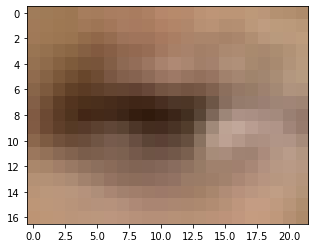

In [13]:
# img test
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(val_data_root+'/img/eye_000010_l.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [14]:
np_inputs = np.expand_dims(cv2.resize(img, (120, 80)), axis=0)
preds = model.predict(np_inputs/255., 1)

repred = preds.reshape((1, 3, 2))
repred[:,:,0] *= 120
repred[:,:,1] *= 80
print (repred)

[[[3.4263375e-04 1.8465631e-05]
  [1.1998269e+02 7.9999855e+01]
  [5.6274555e+01 2.6688585e+01]]]


[0. 0.]
[120.  80.]
[56. 27.]


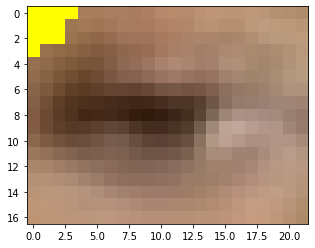

In [15]:
show = img.copy()
for pt in repred[0]:
    print (pt.round())
    show = cv2.circle(show, tuple((pt*0.5).astype(int)), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()